## Imports / Helper Functions / Global Variables

In [71]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from typing import List
from collections import Counter
import seaborn as sns
from tqdm import tqdm
from datetime import date, timedelta

In [72]:
pd.set_option('display.max_columns', 500)

In [73]:
# shorthand for datetime column

DATE_COL = 'Citation Issued DateTime'

In [74]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

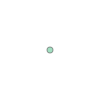

In [75]:
# helper functions for loading in US Census Bureau Geocoding data. This helps correct for ~10k observations with incorrect geolocation.

# 1ST -> 01ST, 2ND -> 02ND, etc., to be compatible
def inv_correct_numbered_streets(string):
    for i in range(1, 10):
        string = string.replace(f'{i}TH', f'0{i}TH')
    # 1st, 2nd and 3rd are special cases
    string = string.replace('1ST', '01ST')
    string = string.replace('2ND', '02ND')
    string = string.replace('3RD', '03RD')
    return string

def coord_string_to_point(coord_string):
    x, y = [float(string) for string in coord_string.split(',')]
    return Point(x, y)

coord_string_to_point("-122.46164710599999,37.77421091000008")

In [76]:
def load_geocoder_data(csv_path='../data/chinook_ct_correct.csv'):
    geo = pd.read_csv(csv_path, header=None)
    geo = geo[geo[2] == 'Match']
    geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
    geo = geo[[1, 5]]
    geo.columns = ['street', 'geom']
    geo.street = geo.street.apply(inv_correct_numbered_streets)
    geo.geom = geo.geom.apply(coord_string_to_point)
    return geo

## Load Data and Fix Incorrect Data

In [77]:
geo_df = load_geocoder_data()
geo_df.head()

,street,geom
0,785 04TH AVE,POINT (-122.46164710599999 37.77421091000008)
1,756 08TH AVE,POINT (-122.46593421399996 37.77422294300004)
2,277 05TH AVE,POINT (-122.46339279499995 37.783491569000034)
3,404 08TH AVE,POINT (-122.46639889099998 37.78064289800005)
4,398 05TH ST,POINT (-122.40188964199996 37.77906450900008)


In [78]:
# create dictionary from pandas dataframe. 

geo_dict = pd.Series(geo_df.geom.values,index=geo_df.street).to_dict()

In [79]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,2022-04-20 12:10:00,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,2022-06-17 16:12:00,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,2022-04-23 15:13:00,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,2022-02-22 11:54:00,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,2022-02-17 13:39:00,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [80]:
# filter to only meter violations

df = df[(df["Violation Description"].str.contains("METER")) | (df["Violation Description"].str.contains("MTR"))]

In [81]:
df["Violation Description"].value_counts()

MTR OUT DT    121571
METER DTN      59298
OT MTR PK        262
Name: Violation Description, dtype: int64

In [82]:
df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [14]:
# using geocoder to fix incorrect geoms

def fix_geom(row):
    if row['Citation Location'] in geo_dict:
        return geo_dict[row['Citation Location']]
    return row['geom']

df['geom'] = df.apply(fix_geom, axis=1)

## Add / Modify Dataframe Columns

In [15]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

In [16]:
# add auxillary date attribute columns based on the datetime. 

df['citation_day'] = df[DATE_COL].dt.day_name()
df['citation_hour'] = df[DATE_COL].dt.hour
df['citation_date'] = df[DATE_COL].dt.date

In [17]:
has_location_string = df[~df['Citation Location'].isnull()]

## Spatial Join with Street Sweeping Dataset

In [18]:
# load dataframe of street segments

unique_streets = pd.read_csv('../data/unique_str_sweep.csv')
unique_streets.loc[:, 'Line'] = unique_streets.Line.apply(wkt.loads)
unique_streets = gpd.GeoDataFrame(unique_streets, geometry='Line')
unique_streets = unique_streets[['Corridor', 'Limits', 'Line']]
unique_streets.crs = 'EPSG:4326'

# save copy of geom column because it will be destroyed by projection / join.
unique_streets['street_geom_3d'] = unique_streets['Line']
unique_streets['street_length'] = unique_streets.street_geom_3d.apply(lambda x: x.length)

In [25]:
# join to get df with street segments
joined = gpd.sjoin_nearest(df, unique_streets, distance_col='dist', how='left')
joined.shape

/Users/tessa/opt/anaconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(181590, 19)

In [26]:
# TODO: figure out how to resolve points that get mapped to multiple streets.
# for now, seems like only a small number have this problem so we ignore it.

has_multiple_citations = joined['Citation Number'].value_counts()
joined = joined[joined['Citation Number'].isin(has_multiple_citations[has_multiple_citations == 1].index)]

## Group and Cluster

In [27]:
# street id: street segment name between perpendicular streets on either side
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [46]:
df_filtered_cols = joined[['citation_date', 'street_id', DATE_COL, 'Citation Location', 'geom', 'citation_day', 'citation_hour', 'street_geom_3d']]

In [47]:
# place each citation into a fifteen minute time bin

df_filtered_cols['time_bin'] = df_filtered_cols[DATE_COL].dt.floor("15min").dt.time.astype(str)

/Users/tessa/opt/anaconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [49]:
# list of time bins: ["00:00:00", "00:15:00", etc.]
all_time_bins = sorted(df_filtered_cols['time_bin'].unique())

In [50]:
# keep each entry for a particular time bin on a particular date + street

df_filtered_cols = df_filtered_cols.drop_duplicates(['citation_date', 'street_id', 'time_bin'])
steet_cit_bins = df_filtered_cols.groupby(['street_id', 'citation_day'])['time_bin'].agg(' '.join)

In [52]:
# creates aggregated counts of citations for each street on each day of the week during each 15 minute interval
def bin_string_to_counter(bin_string):
    bin_counter = Counter(all_time_bins)
    bin_counter.update(bin_string.split(' '))
    return bin_counter

agg_counts = steet_cit_bins.apply(bin_string_to_counter).groupby(['street_id', 'citation_day']).sum()

In [66]:
agg_counts

street_id                         citation_day
01st St Elim St  -  Mission St    Friday          {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                  Monday          {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                  Thursday        {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                  Tuesday         {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                  Wednesday       {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                                                        ...                        
Zoe St Freelon St  -  Brannan St  Monday          {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                  Saturday        {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                  Thursday        {'00:00:00': 1, '07:00:00': 1, '07:15:00': 1, ...
                                  Tuesday         {'0

In [53]:
unique_street_names = agg_counts.index.get_level_values(0).unique()

In [54]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [55]:
# how many Mondays, Tuesdays, etc. there were in Jan 2022 - Feb 2023
df.sort_values("Citation Issued DateTime").head()
sdate = date(2022,1,1)   # start date
edate = date(2023,2,20)   # end date
dates = pd.date_range(sdate, edate-timedelta(days=1),freq='d')
dates_counts = dates.day_name().value_counts().reindex(weekdays)

In [62]:
# list of dataframes, where each dataframe contains counts for how many violations are in each interval on each weekday/segment

list_of_violation_counts = []

for name in tqdm(unique_street_names):
    t = agg_counts.xs(name, level=0, drop_level=False).reset_index().set_index('citation_day').reindex(weekdays, fill_value=Counter(all_time_bins))
    t.street_id = name
    dist_df = pd.concat([t.reset_index(), (pd.DataFrame.from_records(t.time_bin) - 1)], axis=1)
    list_of_violation_counts.append(dist_df)

100%|██████████| 2162/2162 [00:05<00:00, 407.99it/s]


In [90]:
# giant dataframe from list of dataframes
street_violation_counts_df = pd.concat(list_of_violation_counts).drop("time_bin", axis = 1)

street_violation_counts_df.head()



,citation_day,street_id,00:00:00,07:00:00,07:15:00,07:30:00,07:45:00,08:00:00,08:15:00,08:30:00,08:45:00,09:00:00,09:15:00,09:30:00,09:45:00,10:00:00,10:15:00,10:30:00,10:45:00,11:00:00,11:15:00,11:30:00,11:45:00,12:00:00,12:15:00,12:30:00,12:45:00,13:00:00,13:15:00,13:30:00,13:45:00,14:00:00,14:15:00,14:30:00,14:45:00,15:00:00,15:15:00,15:30:00,15:45:00,16:00:00,16:15:00,16:30:00,16:45:00,17:00:00,17:15:00,17:30:00,17:45:00,18:00:00,18:15:00,18:30:00,18:45:00,19:00:00,19:15:00,19:30:00,19:45:00,20:00:00,20:15:00,20:30:00,20:45:00,21:00:00,21:15:00,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00
0,Monday,01st St Elim St - Mission St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Tuesday,01st St Elim St - Mission St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wednesday,01st St Elim St - Mission St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Thursday,01st St Elim St - Mission St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Friday,01st St Elim St - Mission St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
# only filter for 9am-6pm for plots
truncated_times = pd.concat([street_violation_counts_df.iloc[:,0:2], street_violation_counts_df.iloc[:,12:48]], axis=1)

In [92]:
# count_E_and_I.csv is the count of illegal + enforcement on each street segment, 15 min time interval, and day of week
truncated_times.to_csv('../data/count_E_and_I.csv', index=False)

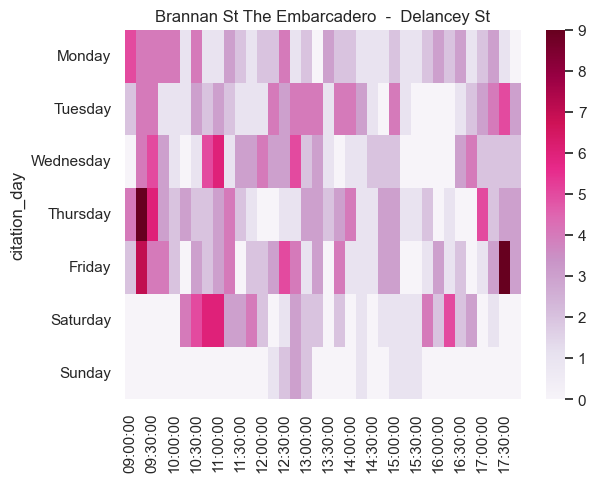

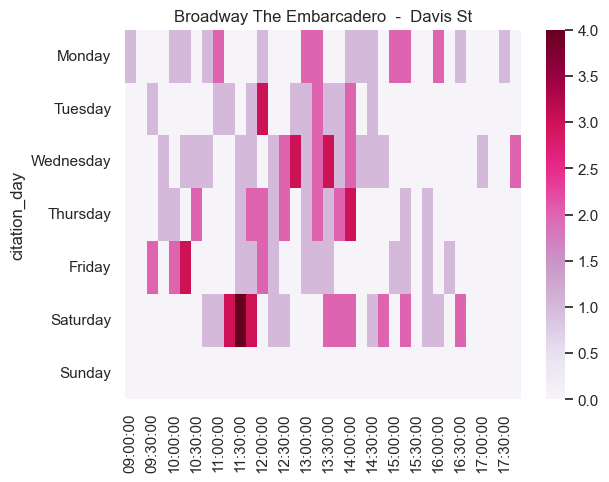

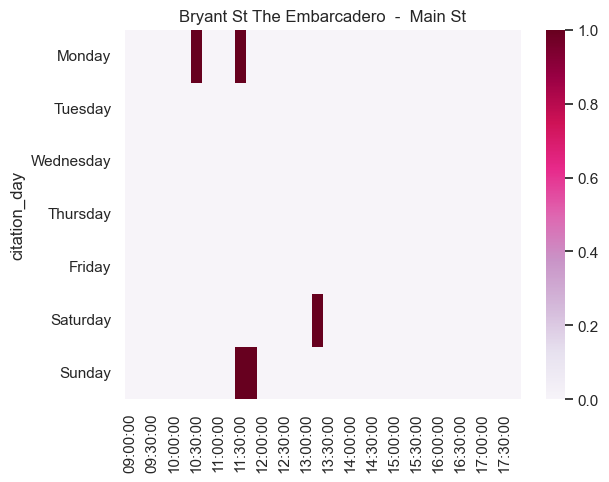

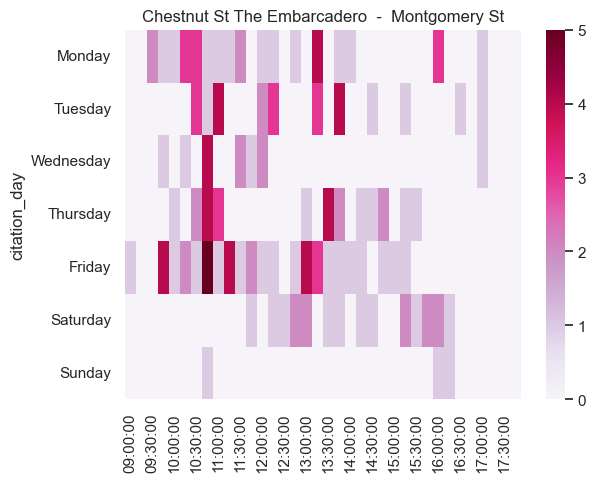

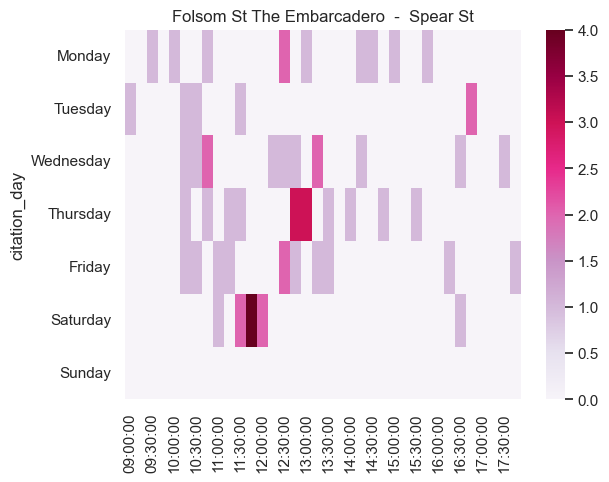

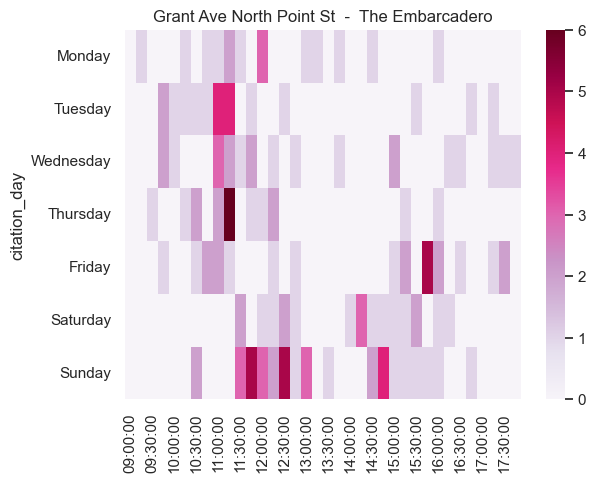

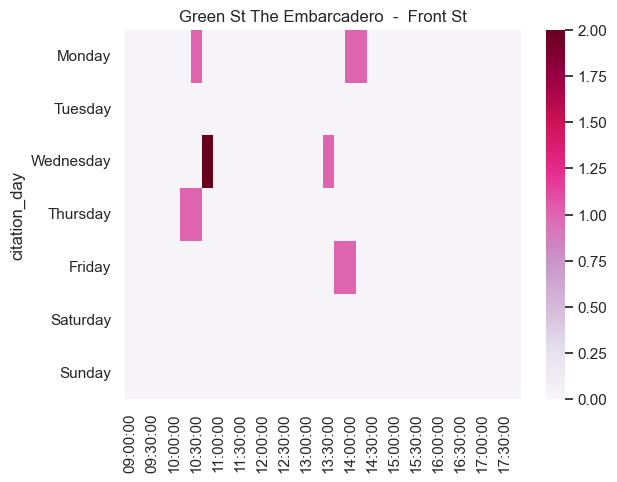

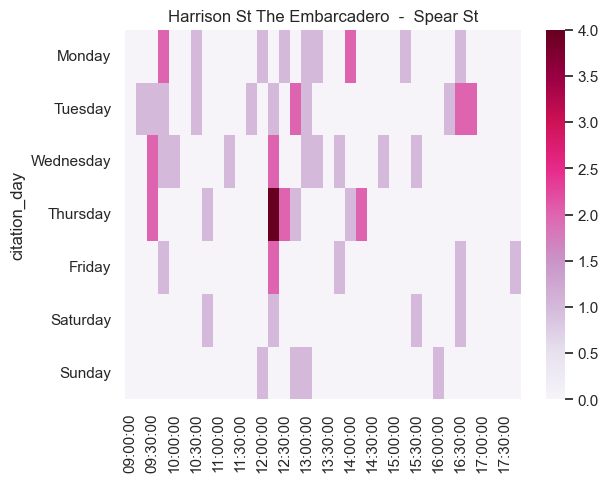

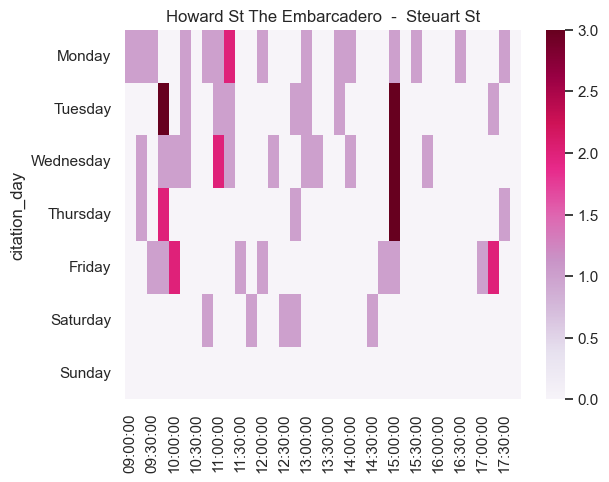

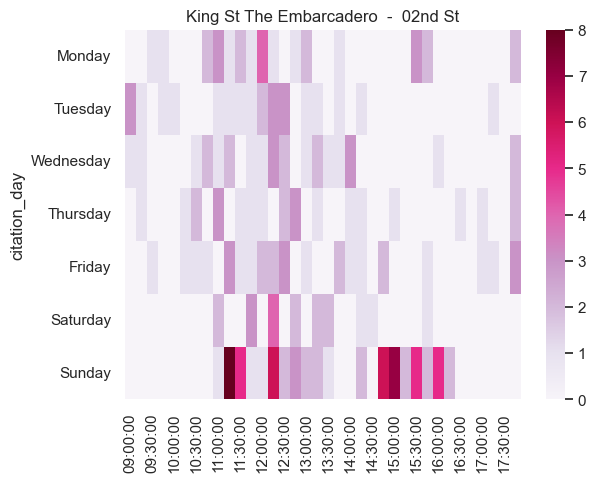

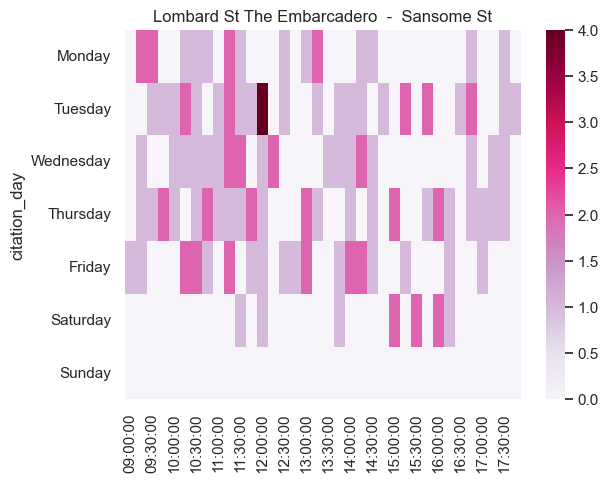

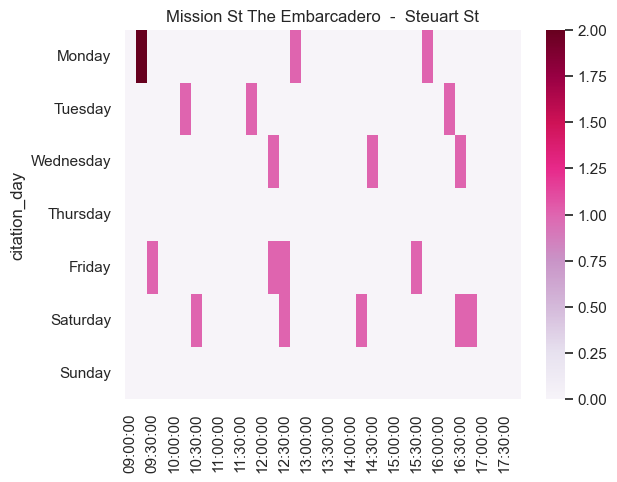

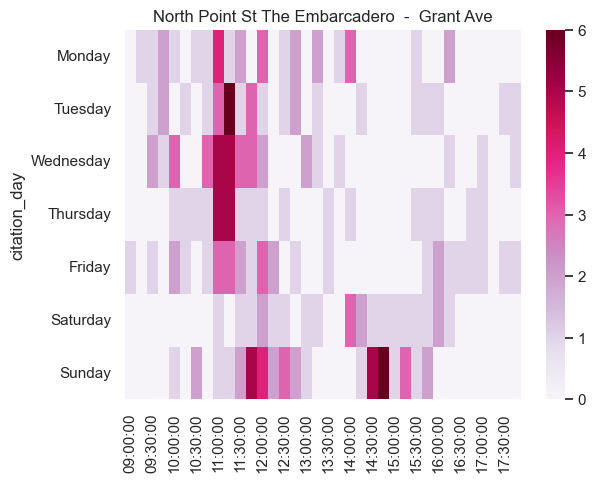

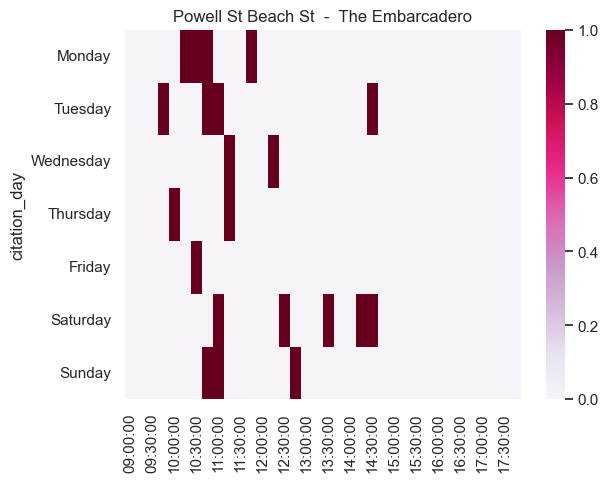

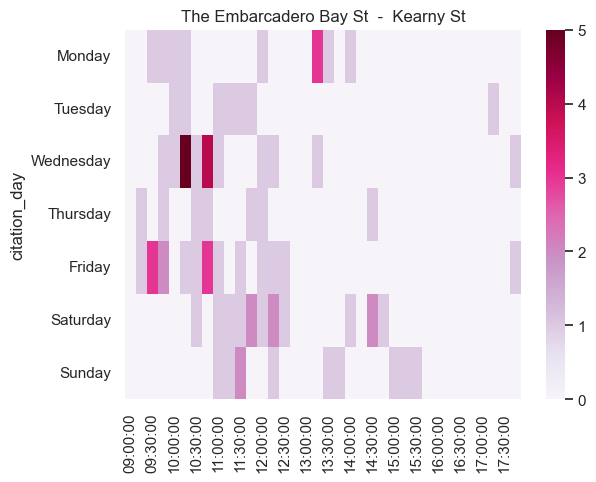

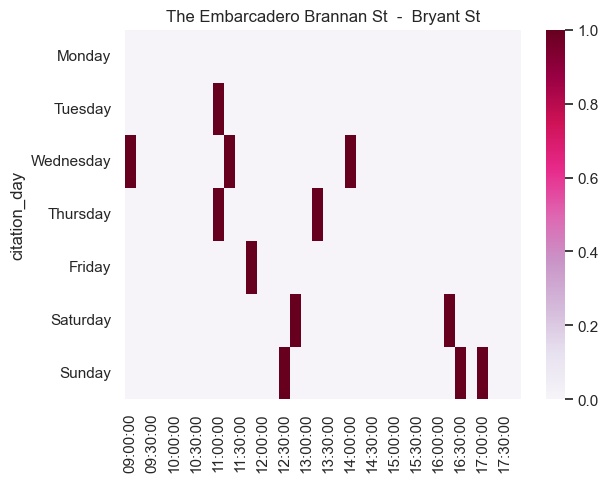

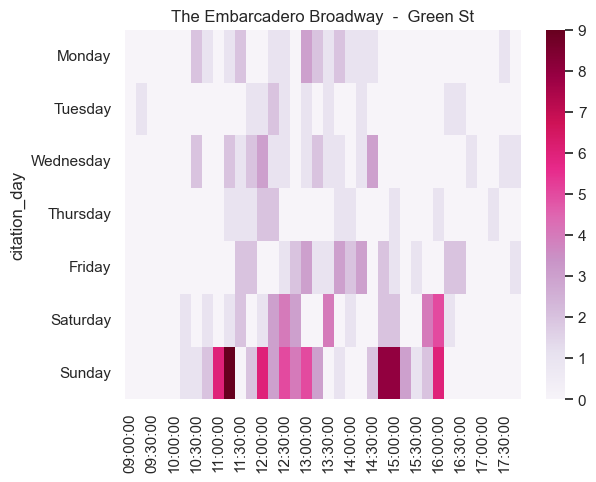

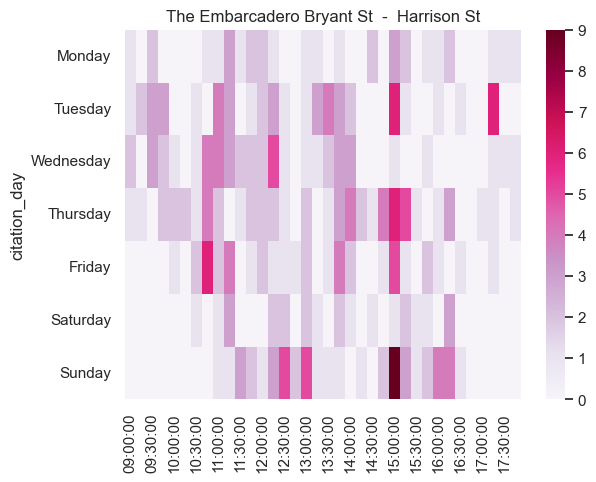

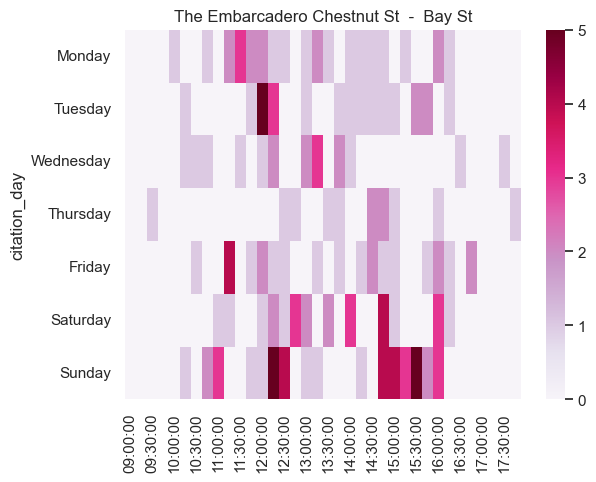

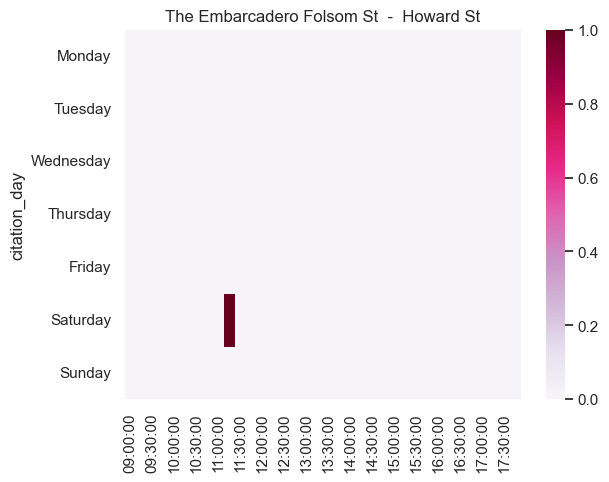

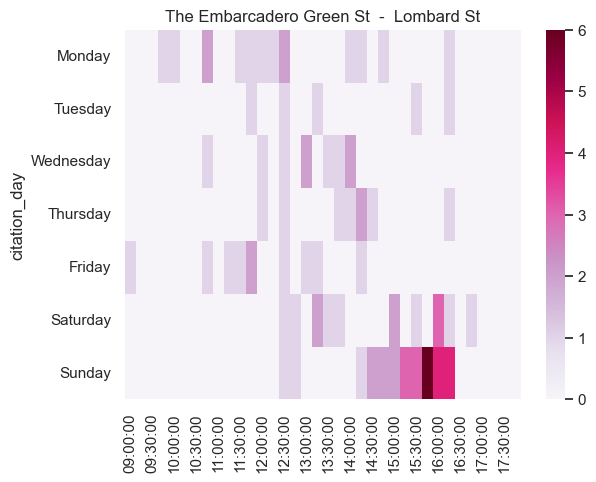

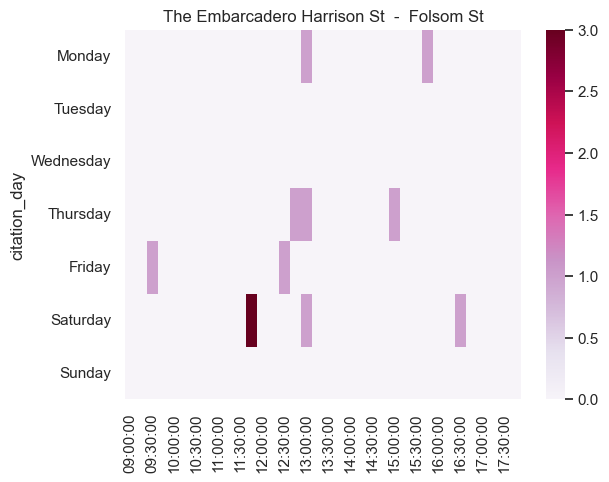

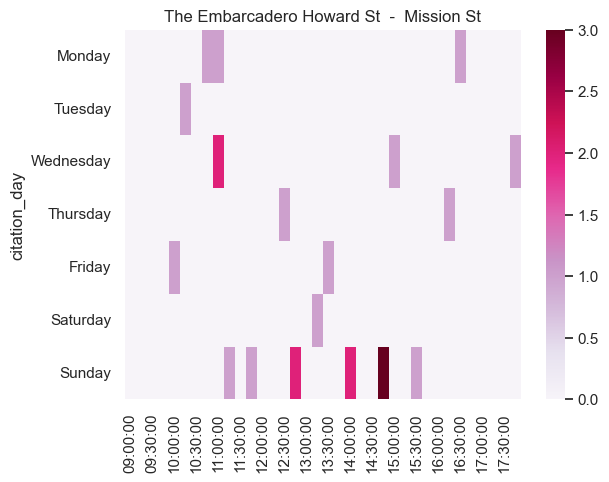

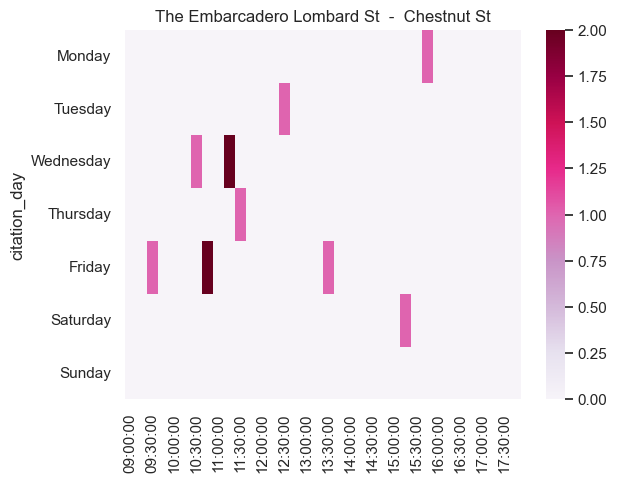

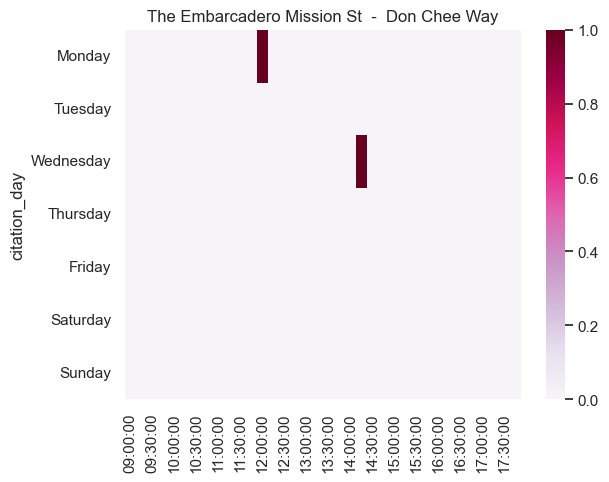

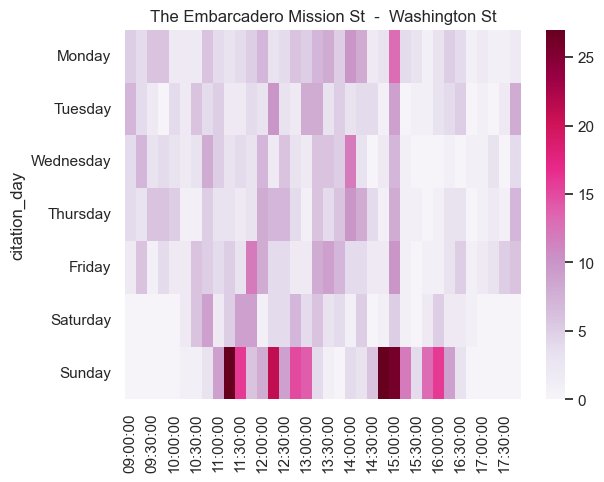

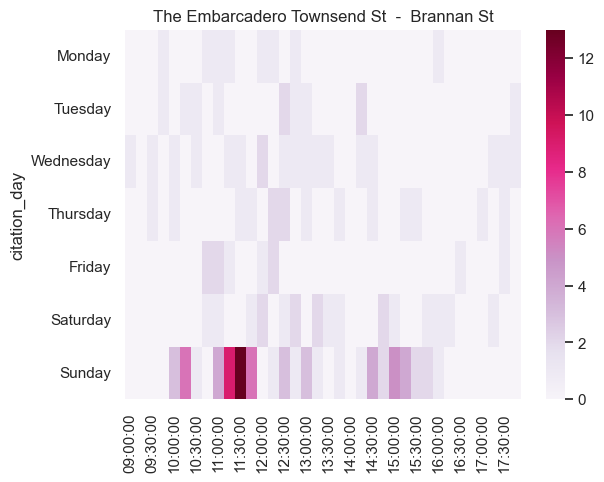

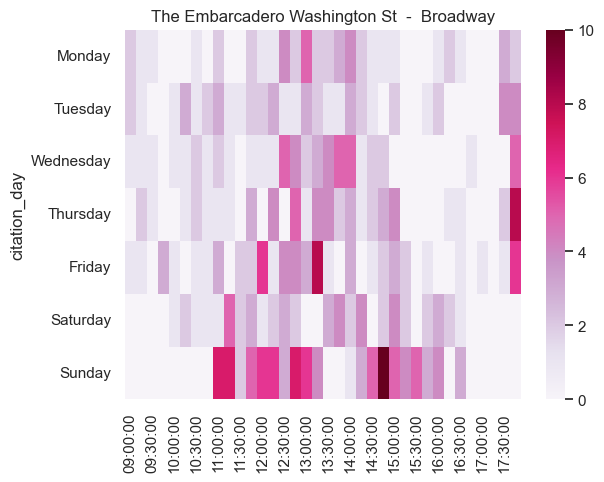

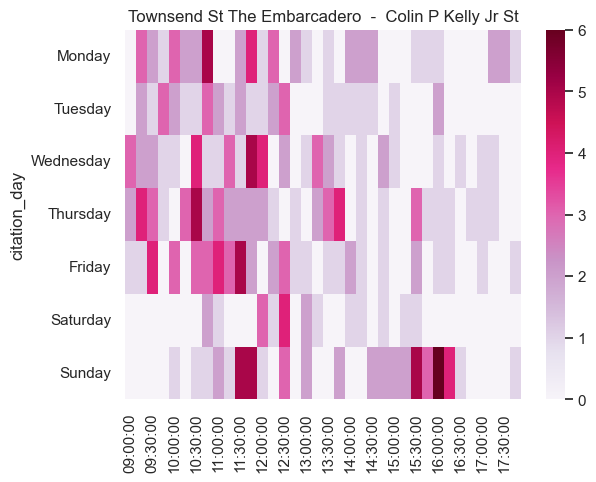

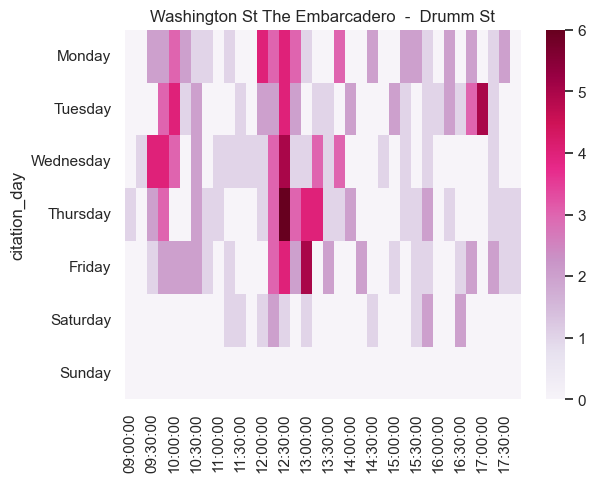

In [65]:
# plots of counts

def plot_dist(street_violation_counts_df, street_id):
    temp_df = street_violation_counts_df[street_violation_counts_df.street_id == street_id]
    #print(temp_df)
    # has all 7 days of the week
    assert temp_df.shape[0] == 7
    temp_df = temp_df[[col for col in temp_df.columns if col not in ['street_id', 'time_bin']]]
    temp_df.set_index('citation_day', inplace=True)
    sns.heatmap(temp_df, cmap = "PuRd").set(title=street_id)
    

for street_id in truncated_times[truncated_times["street_id"].str.contains("Embarcadero")].street_id.unique():
    plot_dist(truncated_times, street_id)
    plt.show()
